In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import random

import pydot
import math
from sklearn.utils import shuffle

from IPython import display

import pickle

np.set_printoptions(precision=3, suppress=True)

Using TensorFlow backend.


In [2]:
COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
                "dim5", "dim6", "dim7", "dim8", 
                "dim9", "dim10", "label"]
LABEL_NAME = "label"
INPUT_NAMES = list(COLUMN_NAMES)
INPUT_NAMES.remove(LABEL_NAME)
trajectory_list = pickle.load(open("N-Dim_Doublewell/trajectory_list.p", "rb"))
trajectory_label_list = pickle.load(open("N-Dim_Doublewell/trajectory_label_list.p", "rb"))
BATCH_SIZE = 64
#SHUFFLE_BUFFER_SIZE = 1000000
CORES_USED = 3
DIMENSIONS = 10
# sets a random seed for reproducibility of the shuffling process
SEED = 5
OFFSET = 5


In [3]:
# additional section can be used for generation of present/future pairs
def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return present_trajectory_list, future_trajectory_list

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False, progress_label = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            if progress_label == False:
                snapshot_label_list.append(trajectory_label)
            else:
                # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
                # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
                # indicating a sucessfull transition a progress along the snapshots is calculated based on
                # the position within the trajectory and the total trajectory length.
                # For present/future lists, the offset needs to be taken into account in the denominator
                # If the dataset is a future variant of an offset trajectory list the progress label 
                # needs to additionally take the offset into account in the nominator.
                if trajectory_label == 0.0 or trajectory_label == 1.0:
                    snapshot_label_list.append(trajectory_label)
                else:
                    if future == True:
                        snapshot_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                    else:
                        snapshot_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list)

def show_batch(dataset):
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))


In [4]:
#snapshot_list, snapshot_label_list = get_snapshot_and_label_list(trajectory_list, trajectory_label_list)

# Sets a split size for train and test data set
#DATASET_SIZE = len(snapshot_label_list)
#TRAIN_SIZE = int(DATASET_SIZE * 0.7)
SPLIT_RATIO = 0.7
BOTTLENECK_SIZE = 2
LABEL_LOSS_WEIGHT = 1.0
RECONSTRUCTION_LOSS_WEIGHT = 1.0

In [5]:
def shuffled_train_test_split(trajectory_list, trajectory_label_list, split_ratio, offset = 0, progress_label = False):
    assert isinstance(split_ratio, float), "Split ratio needs to be a of type float"
    if offset == 0 or offset == None:
        snapshot_list, snapshot_label_list = get_snapshot_and_label_list(trajectory_list, trajectory_label_list, progress_label=progress_label)
        snapshot_list, snapshot_label_list = shuffle(snapshot_list, snapshot_label_list)
        train_size = int(len(snapshot_label_list) * split_ratio)
        train_snapshot_list = snapshot_list[:train_size].copy()
        test_snapshot_list = snapshot_list[train_size:].copy()
        train_snapshot_label_list = snapshot_label_list[:train_size].copy()
        test_snapshot_label_list = snapshot_label_list[train_size:].copy()
        
        return train_snapshot_list, train_snapshot_label_list, test_snapshot_list, test_snapshot_label_list
    else:
        present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, offset)
        present_snapshot_list, _ = get_snapshot_and_label_list(
            present_trajectory_list, trajectory_label_list, offset)
        future_snapshot_list, future_snapshot_label_list = get_snapshot_and_label_list(
            future_trajectory_list, trajectory_label_list, offset, future = True, progress_label=progress_label)
        present_snapshot_list, future_snapshot_list, future_snapshot_label_list = shuffle(
            present_snapshot_list, future_snapshot_list, future_snapshot_label_list)
        train_size = int(len(future_snapshot_label_list) * split_ratio)
        
        train_present_snapshot_list = present_snapshot_list[:train_size].copy()
        test_present_snapshot_list = present_snapshot_list[train_size:].copy()
        train_future_snapshot_list = future_snapshot_list[:train_size].copy()
        test_future_snapshot_list = future_snapshot_list[train_size:].copy()
        train_future_snapshot_label_list = future_snapshot_label_list[:train_size].copy()
        test_future_snapshot_label_list = future_snapshot_label_list[train_size:].copy()   
        return train_present_snapshot_list, train_future_snapshot_list, train_future_snapshot_label_list, test_present_snapshot_list, test_future_snapshot_list, test_future_snapshot_label_list



train_snapshot_list, train_snapshot_label_list, test_snapshot_list, test_snapshot_label_list = shuffled_train_test_split(
    trajectory_list, trajectory_label_list, SPLIT_RATIO, offset = 0, progress_label=False)
#train_present_snapshot_list, train_future_snapshot_list, train_future_snapshot_label_list, test_present_snapshot_list, test_future_snapshot_list, test_future_snapshot_label_list =shuffled_train_test_split(
#    trajectory_list, trajectory_label_list, SPLIT_RATIO, offset = OFFSET, progress_label = False)

DATASET_SIZE = len(train_snapshot_list) + len(test_snapshot_list)

In [6]:
# generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
train_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": train_snapshot_list},
                                               {"label": train_snapshot_label_list, 
                                                "reconstruction": train_snapshot_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": test_snapshot_list},
                                               {"label": test_snapshot_label_list, 
                                                "reconstruction": test_snapshot_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE)
#train_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": train_present_snapshot_list},
#                                               {"label": train_future_snapshot_label_list, 
#                                                "reconstruction": train_future_snapshot_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE)
#test_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": test_present_snapshot_list},
#                                               {"label": test_future_snapshot_label_list, 
#                                                "reconstruction": test_future_snapshot_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE)

#ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": snapshot_list},
#                                        {"label": snapshot_label_list, 
#                                         "reconstruction": snapshot_list})).shuffle(DATASET_SIZE)
#train_ds = ds.take(TRAIN_SIZE).batch(BATCH_SIZE)
#test_ds = ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)

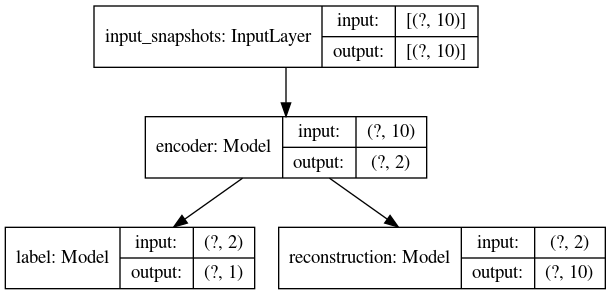

In [7]:
"""encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = keras.layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(3)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = keras.layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = keras.layers.Reshape((4, 4, 1))(decoder_input)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = keras.layers.UpSampling2D(3)(x)
x = keras.layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()"""

encoder_input = keras.Input(shape=(DIMENSIONS,),name="input_snapshots")
x = keras.layers.Dense(DIMENSIONS, activation= 'tanh')(encoder_input)
x = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x)
x = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x)
encoder_output = keras.layers.Dense(BOTTLENECK_SIZE, activation='tanh', name='bottleneck')(x)

encoder = keras.Model(encoder_input, encoder_output, name ="encoder")
#encoder.summary()

decoder_input = keras.Input(shape=(BOTTLENECK_SIZE,), name ="encoded_snapshots")

x1 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(decoder_input)
x1 = keras.layers.Dense(DIMENSIONS, activation='tanh')(x1)
decoder_output_1 = keras.layers.Dense(1, activation='tanh',name="label")(x1)
decoder_1 = keras.Model(decoder_input, decoder_output_1, name="label")
#decoder_1.summary()

x2 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(decoder_input)
x2 = keras.layers.Dense(DIMENSIONS*2, activation='tanh')(x2)
decoder_output_2 = keras.layers.Dense(DIMENSIONS, activation='tanh',name="reconstruction")(x2)
decoder_2 = keras.Model(decoder_input, decoder_output_2, name="reconstruction")
#decoder_2.summary()

autoencoder_input = keras.Input(shape=(DIMENSIONS,), name="input_snapshots")
encoded_snaphot = encoder(autoencoder_input)
label_snapshot = decoder_1(encoded_snaphot)
reconstructed_snapshot = decoder_2(encoded_snaphot)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=[label_snapshot,reconstructed_snapshot])

model_layout = keras.utils.plot_model(autoencoder, 'multi_input_and_output_model.png', show_shapes=True)
display.display(model_layout)
#display.display(keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_1, 'decoder_1.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_2, 'decoder_2.png', show_shapes=True))


In [8]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'label':keras.losses.MeanAbsoluteError(),
                      'reconstruction': keras.losses.MeanAbsoluteError()},
              loss_weights=[LABEL_LOSS_WEIGHT, RECONSTRUCTION_LOSS_WEIGHT])

In [9]:
autoencoder.fit(train_ds,epochs=10)


Train for 2522 steps
Epoch 1/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4475 - label_loss: 0.0540 - reconstruction_loss: 0.3935
Epoch 2/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4262 - label_loss: 0.0391 - reconstruction_loss: 0.3872
Epoch 3/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4232 - label_loss: 0.0374 - reconstruction_loss: 0.3858
Epoch 4/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4168 - label_loss: 0.0356 - reconstruction_loss: 0.3812
Epoch 5/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4106 - label_loss: 0.0341 - reconstruction_loss: 0.3765
Epoch 6/10
2522/2522 [==============================] - 4s 2ms/step - loss: 0.4092 - label_loss: 0.0336 - reconstruction_loss: 0.3756
Epoch 7/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.4085 - label_loss: 0.0333 - reconstruction_loss: 0.3752
Epoch 8/10
2522/2522 [===================

In [52]:
STEP_NUMBER = int(len(test_snapshot_list)/BATCH_SIZE)
autoencoder.evaluate(test_ds, verbose=1, steps = STEP_NUMBER)

1080/1080 [==============================] - 2s 1ms/step - loss: 0.4076 - label_loss: 0.0324 - reconstruction_loss: 0.3752


[0.4075679966696986, 0.03240565, 0.3751626]

In [38]:
def map_generated_labels(model, x_list, y_list, dimensions, additional_dim_val, x_var_pos, y_var_pos):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_row.append(model.predict([[x if x_var_pos == pos_nr else y if y_var_pos == pos_nr else additional_dim_val for pos_nr in range(dimensions)]])[0][0][0])
        label_map.append(label_current_row)
    return np.array(label_map)

In [12]:
def map_given_labels_efficiently(snapshot_list, snapshot_label_list, x_list, y_list, x_var_pos, y_var_pos):
    x_nr = len(x_list)
    y_nr = len(y_list)
    min_x = min(x_list)
    max_x = max(x_list)
    min_y = min(y_list)
    max_y = max(y_list)
    # generate a list of lists of lists to store all labels in
    label_map = [[[] for y in y_list] for x in x_list]
    # sort the labels of each snapshot to the corresponding "positions" in the grid (by sorting them in the list)
    for snapshot_nr in range(len(snapshot_list)):
        x_snap = snapshot_list[snapshot_nr][x_var_pos]
        y_snap = snapshot_list[snapshot_nr][y_var_pos]
        # int to be able to use for iteration, round to round to closest full number, 
        # i-min_x to offset to start at 0, /2.0*(x-nr-1) to rescale
        x_int = int(round((x_snap - min_x)/2.0*(x_nr-1)))
        y_int = int(round((y_snap - min_y)/2.0*(y_nr-1)))
        label_map[x_int][y_int].append(snapshot_label_list[snapshot_nr])

    for row_ind in range(len(label_map)):
        for col_ind in range(len(label_map[row_ind])):
            if len(label_map[row_ind][col_ind]) > 0:
                label_map[row_ind][col_ind] = np.mean(label_map[row_ind][col_ind])
            else:
                label_map[row_ind][col_ind] = float('NaN')
    return label_map

In [13]:
def plot_heatmap(label_map, title, x_name, y_name, vmin, vmax):
    plt.close()
    # use transpose to rotate the map into the right orientation
    # use [::-1] to invert the new y_axis
    fig, ax = plt.subplots()
    plt.imshow(np.transpose(label_map)[::-1], cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
    #plt.axis('off')
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False, # labels along the bottom edge are off
        left = False,
        labelleft= False)     
    plt.xlabel("{}".format(x_name))
    plt.ylabel("{}".format(y_name))
    plt.savefig(title)
    plt.show()

0 1


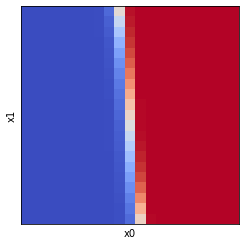

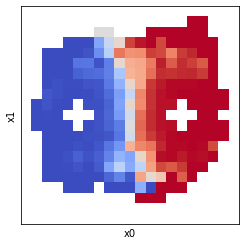

In [15]:
RESOLUTION = 21
for i in range(2):
    for j in range(2):
        if j > i:
            print(i, j)
            label_map_generated = map_generated_labels(autoencoder, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1, RESOLUTION), DIMENSIONS, 0, i, j)
            label_map_given = map_given_labels_efficiently(train_snapshot_list, train_snapshot_label_list, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1,RESOLUTION), i, j)
            plot_heatmap(label_map_generated, "{}{}_21_label_map_generated.png".format(i,j), "x{}".format(i), "x{}".format(j), 0, 1)
            plot_heatmap(label_map_given, "{}{}_21_label_map_given.png".format(i,j), "x{}".format(i), "x{}".format(j), 0, 1)

In [16]:
def map_generated_bottleneck(model, x_list, y_list, dimensions, additional_dim_val, x_var_pos, y_var_pos, bottlenek_node_nr):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    output_map = [[] for i in range(bottlenek_node_nr)]
    for x in x_list:
        output_current_row = [[] for i in range(bottlenek_node_nr)]
        for y in y_list:
            prediction = model.predict([[x if x_var_pos == pos_nr else y if y_var_pos == pos_nr else additional_dim_val for pos_nr in range(dimensions)]])[0]
            for subrow_nr in range(bottlenek_node_nr):
                output_current_row[subrow_nr].append(prediction[subrow_nr])      
        for subarray_nr in range(bottlenek_node_nr):
            output_map[subarray_nr].append(output_current_row[subarray_nr])
    return np.array(output_map)

bottleneck_map_generated = map_generated_bottleneck(encoder, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1, RESOLUTION), DIMENSIONS, 0, 0, 1, 2)



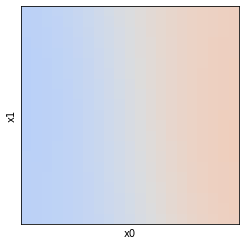

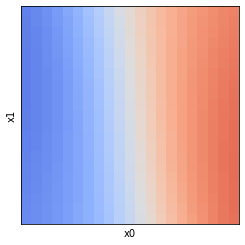

In [17]:
plot_heatmap(bottleneck_map_generated[0], "{}{}_21_bottleneck_map_generated_b0.png".format(0,1), "x0", "x1", -1, 1)
#plot_heatmap(bottleneck_map_generated[0], "{}{}_21_bottleneck_map_generated_b0_unscaled_colorcode.png".format(0,1), "x0", "x1", None, None)
plot_heatmap(bottleneck_map_generated[1], "{}{}_21_bottleneck_map_generated_b1.png".format(0,1), "x0", "x1", -1, 1)
#plot_heatmap(bottleneck_map_generated[1], "{}{}_21_bottleneck_map_generated_b1_unscaled_colocode.png".format(0,1), "x0", "x1", None, None)

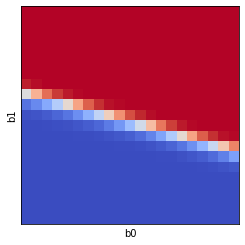

In [18]:
def map_generated_label_from_bn(model, x_list, y_list, dimensions, additional_dim_val, x_var_pos, y_var_pos):
    assert x_var_pos != y_var_pos, "x_var_pos and y_var_pos need to differ"
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_row.append(model.predict([[x if x_var_pos == pos_nr else y if y_var_pos == pos_nr else additional_dim_val for pos_nr in range(dimensions)]])[0][0])
        label_map.append(label_current_row)
    return np.array(label_map)
 
label_map_from_bn = map_generated_label_from_bn(decoder_1, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1, RESOLUTION), BOTTLENECK_SIZE, 0, 0, 1)
plot_heatmap(label_map_from_bn, "{}{}_21_label_map_from_bn.png".format(0,1), "b0", "b1", 0, 1)


In [19]:
# misusing map generated_bottleneck here, since it has the same functionality of generating an array of maps for each output
reconstructed_map_from_bn = map_generated_bottleneck(decoder_2, np.linspace(-1,1,RESOLUTION), np.linspace(-1,1, RESOLUTION), BOTTLENECK_SIZE, 0, 0, 1, 10)





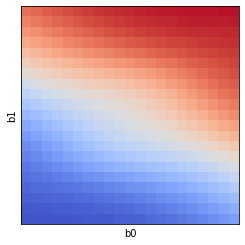

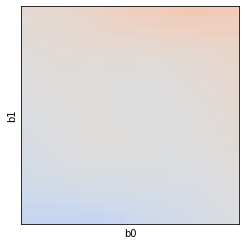

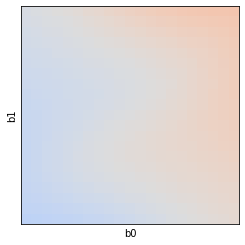

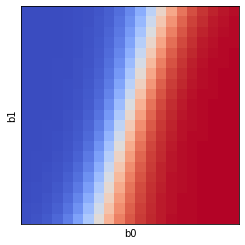

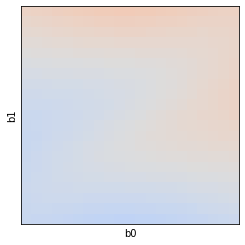

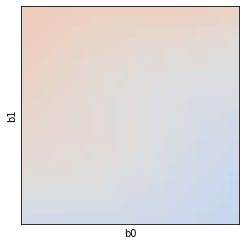

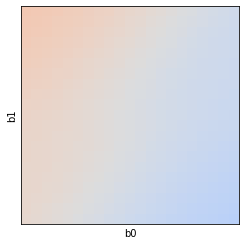

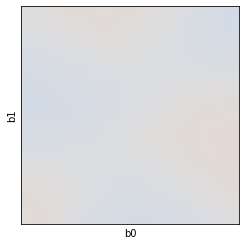

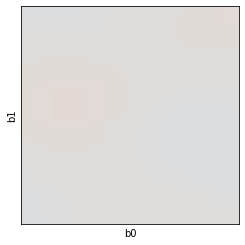

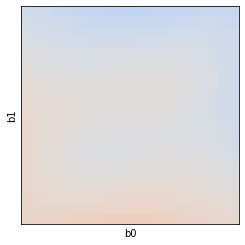

In [20]:
plot_heatmap(reconstructed_map_from_bn[0], "{}{}_21_label_map_from_bn_0.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[0], "{}{}_21_label_map_from_bn_0_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[1], "{}{}_21_label_map_from_bn_1.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[1], "{}{}_21_label_map_from_bn_1_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[2], "{}{}_21_label_map_from_bn_2.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[2], "{}{}_21_label_map_from_bn_2_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[3], "{}{}_21_label_map_from_bn_3.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[3], "{}{}_21_label_map_from_bn_3_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[4], "{}{}_21_label_map_from_bn_4.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[4], "{}{}_21_label_map_from_bn_4_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[5], "{}{}_21_label_map_from_bn_5.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[5], "{}{}_21_label_map_from_bn_5_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[6], "{}{}_21_label_map_from_bn_6.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[6], "{}{}_21_label_map_from_bn_6_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[7], "{}{}_21_label_map_from_bn_7.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[7], "{}{}_21_label_map_from_bn_7_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[8], "{}{}_21_label_map_from_bn_8.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[8], "{}{}_21_label_map_from_bn_8_unscaled.png".format(0,1), "b0", "b1", None, None)
plot_heatmap(reconstructed_map_from_bn[9], "{}{}_21_label_map_from_bn_9.png".format(0,1), "b0", "b1", -1, 1)
#plot_heatmap(reconstructed_map_from_bn[9], "{}{}_21_label_map_from_bn_9_unscaled.png".format(0,1), "b0", "b1", None, None)

In [93]:
"""# modify original numpy arrays, generate new datasets and use that for the comparison 
def input_perturbation_efficiently(model, test_ds, snapshot_list, snapshot_label_list, perturbation, check_vars, repetitions):
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps= 1000)
    meta_loss_list = []
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[],[],[]]
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            #print(snapshot_list)
            perturbed_snapshot_list = snapshot_list.copy()
            # generates random perturbation scaling array, with values uniformly distributed around 1 
            # ranging from 1 - perturbation to 1 + perturbation
            rand_array = (np.random.rand(len(snapshot_list), 1)-0.5)*(2*perturbation)+1
            # multiply corresponding column of the dataset with perturbation scaling array
            perturbed_snapshot_list[:,variable_nr] = perturbed_snapshot_list[:,variable_nr]*rand_array[:,0]
            # make a new perturbed Dataset to feed into the previously trained model
            perturbed_ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": perturbed_snapshot_list},
                                            {"label":snapshot_label_list, 
                                             "reconstruction":snapshot_list})).shuffle(DATASET_SIZE)
            perturbed_test_ds = perturbed_ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)
            # calculate the different losses with the new dataset
            pert_t_loss, pert_l_loss, pert_r_loss = model.evaluate(perturbed_test_ds, verbose=0, steps = 1000)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,pert_t_loss-orig_t_loss))
            loss_list[1].append(max(0,pert_l_loss-orig_l_loss))
            loss_list[2].append(max(0,pert_r_loss-orig_r_loss))
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    return np.array(sum(meta_loss_list)/repetitions)"""
pass

In [80]:
class PerturbDataset(object):
    def __init__(self, perturb_along, perturbation):
        self.perturb_along = perturb_along
        self.perturbation = perturbation
        
    def __call__(self, features, labels):
        perturb_along = self.perturb_along
        perturbation = self.perturbation
        # iterates over all keys of the features (here only 1)
        # generates an array with only value "1" in all columns except for the perturbed column
        # which contains random values between 1 - perturbation and 1 + perturbation
        # multiplies the input with that matrix to perturb exactly that column  of the input uniformly
        for key in features.keys():
            rand_array = (np.random.rand(BATCH_SIZE, 1)-0.5)*(2*perturbation)+1
            mult_array = np.ones((BATCH_SIZE, DIMENSIONS))
            mult_array[:,perturb_along] = mult_array[:,perturb_along]*rand_array[:,0]
            features[key] = features[key] * mult_array
        
        return features, labels
    
def input_perturbation_most_efficient(model, test_ds, perturbation, check_vars, repetitions):
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps = STEP_NUMBER)
    meta_loss_list = []
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[],[],[]]
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            perturbed_test_ds = test_ds.map(PerturbDataset(variable_nr, perturbation))
            # calculate the different losses with the new dataset
            pert_t_loss, pert_l_loss, pert_r_loss = model.evaluate(perturbed_test_ds, verbose=0, steps = STEP_NUMBER)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,pert_t_loss-orig_t_loss))
            loss_list[1].append(max(0,pert_l_loss-orig_l_loss))
            loss_list[2].append(max(0,pert_r_loss-orig_r_loss))
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    return np.array(sum(meta_loss_list)/repetitions)

perturbed_loss_list = input_perturbation_most_efficient(autoencoder, test_ds, 0.5, range(10), 10)

Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
Repetition 2.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
Repetition 3.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
Repetition 4.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturb

In [81]:
def plot_input_importance(loss_list, loss_type, name, perturbation):
    variable_nr = len(loss_list[0])
    plt.bar(range(variable_nr),loss_list[loss_type])
    if perturbation == None:
        plt.savefig("{}_{}.png".format(name,loss_type))        
    else:
        plt.savefig("{}_{}_pert_{}.png".format(name,loss_type,perturbation))
    plt.close()

plot_input_importance(pertubred_loss_list,0,"Input_perturbation","0.5")
plot_input_importance(pertubred_loss_list,1,"Input_perturbation","0.5")
plot_input_importance(pertubred_loss_list,2,"Input_perturbation","0.5")


In [82]:
def get_column_mean_of_batched_ds(dataset):
#    for batch, label in ds.take(1):
#        assert len(batch["input_snapshots"].shape) > 1, "Dataset needs to be batched before using this function"
    # takes all batches and concatenates them back together to get a big list of snapshots
    # np.mean is then used to calculate the mean of each column
    return np.mean(np.concatenate(np.array([batch["input_snapshots"].numpy() for batch, label in dataset])),axis = 0)

class TakeColumnMean(object):
    def __init__(self, take_mean_along, column_mean, dimensions):
        self.take_mean_along = take_mean_along
        self.column_mean = column_mean
        self.dimensions = dimensions
        
    def __call__(self, features, labels):
        take_mean_along = self.take_mean_along
        column_mean = self.column_mean
        dimensions = self.dimensions
        # iterates over all keys of the features (here only 1)
        # generates an array with only value "1" in all columns except for the perturbed column
        # which contains random values between 1 - perturbation and 1 + perturbation
        # multiplies the input with that matrix to perturb exactly that column  of the input uniformly
        for key in features.keys():
            mult_array = np.ones((BATCH_SIZE, dimensions))
            add_array = np.zeros((BATCH_SIZE, dimensions))
            mult_array[:,take_mean_along] = 0.0
            add_array[:,take_mean_along] = column_mean
            features[key] = features[key] * mult_array
            features[key] = features[key] + add_array
        return features, labels

def improved_stepwise(model, test_ds, check_vars, repetitions):
    if repetitions > 1:
        "Evaluation occurs on the basis of all batches of size BATCH_SIZE, thereby yielding a reliably result even at only one repetition."
    orig_t_loss, orig_l_loss, orig_r_loss = model.evaluate(test_ds, verbose=0, steps = STEP_NUMBER)
    meta_loss_list = []
    mean_value_array = get_column_mean_of_batched_ds(test_ds)
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[],[],[]]
        test_ds_list = []
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            m_col_test_ds = test_ds.map(TakeColumnMean(variable_nr, mean_value_array[variable_nr],DIMENSIONS))
            test_ds_list.append(m_col_test_ds)
            # calculate the different losses with the new dataset
            m_col_t_loss, m_col_l_loss, m_col_r_loss = model.evaluate(m_col_test_ds, verbose=0, steps = STEP_NUMBER)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,m_col_t_loss-orig_t_loss))
            loss_list[1].append(max(0,m_col_l_loss-orig_l_loss))
            loss_list[2].append(max(0,m_col_r_loss-orig_r_loss))
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    return np.array(sum(meta_loss_list)/repetitions), test_ds_list

In [72]:
mean_loss_list, test_ds_list = improved_stepwise(autoencoder, test_ds, range(10), 1)


Repetition 1.
	Perturbing variable 0.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 3.
	Perturbing variable 4.
	Perturbing variable 5.
	Perturbing variable 6.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 9.
[array([[0.911, 0.001, 0.   , 0.088, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.998, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.436, 0.   , 0.   , 0.563, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]])]


In [79]:
plot_input_importance(mean_loss_list,1,"Stepwise", None)


In [83]:
print(encoder.predict(test_ds))

[[ 0.015 -0.419]
 [-0.071 -0.6  ]
 [-0.391 -0.178]
 ...
 [ 0.387  0.475]
 [ 0.399  0.264]
 [-0.004 -0.322]]


In [91]:
test_bn_ds = tf.data.Dataset.from_tensor_slices(({"encoded_snapshots": encoder.predict(test_ds)},
                                            {"label": test_snapshot_label_list})).shuffle(DATASET_SIZE).batch(BATCH_SIZE)
print(test_bn_ds)
decoder_1.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'label':keras.losses.MeanAbsoluteError()})
features_list = [layer.output for layer in encoder.layers]
#print(features_list)
decoder_1.evaluate(test_bn_ds, verbose=0, steps = STEP_NUMBER)

<BatchDataset shapes: ({encoded_snapshots: (None, 2)}, {label: (None,)}), types: ({encoded_snapshots: tf.float32}, {label: tf.float64})>


0.4968751705079167

In [86]:
def get_column_mean_of_batched_ds(dataset):
#    for batch, label in ds.take(1):
#        assert len(batch["input_snapshots"].shape) > 1, "Dataset needs to be batched before using this function"
    # takes all batches and concatenates them back together to get a big list of snapshots
    # np.mean is then used to calculate the mean of each column
    return np.mean(np.concatenate(np.array([batch["encoded_snapshots"].numpy() for batch, label in dataset])),axis = 0)

def improved_stepwise_bn(model, test_ds, check_vars, repetitions):
    orig_l_loss = model.evaluate(test_ds, verbose=0, steps = STEP_NUMBER)
    meta_loss_list = []
    mean_value_array = get_column_mean_of_batched_ds(test_ds)
    for repetition in range(repetitions):
        print("Repetition {}.".format(repetition+1))
        loss_list = [[]]
        for variable_nr in check_vars:
            print("\tPerturbing variable {}.".format(variable_nr))
            m_col_test_ds = test_ds.map(TakeColumnMean(variable_nr, mean_value_array[variable_nr],BOTTLENECK_SIZE))
            # calculate the different losses with the new dataset
            m_col_l_loss = model.evaluate(m_col_test_ds, verbose=0, steps = STEP_NUMBER)
            # append the losses to a collective list for later comparison
            loss_list[0].append(max(0,m_col_l_loss-orig_l_loss))
        for row_nr in range(len(loss_list)):
            full_loss = sum(loss_list[row_nr])
            for col_nr in range(len(loss_list[row_nr])):
                if full_loss > 0:
                    loss_list[row_nr][col_nr] = loss_list[row_nr][col_nr]/full_loss
                else:
                    loss_list[row_nr][col_nr] = 0
        meta_loss_list.append(np.array(loss_list))
    return np.array(sum(meta_loss_list)/repetitions)

loss_list = improved_stepwise_bn(decoder_1, test_bn_ds, range(2), 10)


"""
Trying to map the train_ds in such a way that the input is replaced by the output of the bottleneck
Currently the fact that predict returns unbatched results appears to be the problem
"""

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [79]:
print(loss_list)
plot_input_importance(loss_list,0,"Stepwise_bn", None)

[[0.  0.8]]


In [84]:
print(autoencoder([0,0]))

InvalidArgumentError: In[0] is not a matrix. Instead it has shape [] [Op:MatMul]

In [107]:
# accessing the output of all layers

features_list = [layer.output for layer in encoder.layers]
#print(features_list)
feat_extraction_model = keras.Model(inputs=encoder.input, outputs=features_list[-1])

img = np.random.random((1,10)).astype('float32')
print(encoder(img).numpy())
extracted_features = feat_extraction_model(img)
print(extracted_features.numpy())

[[-0.738  0.041]]
[[-0.738  0.041]]


In [130]:
example_batch, label_batch = next(iter(train_sl_ds))    


# with a Sequential model
output = K.function([model.layers[0].input],
                    [model.layers[3].output])
layer_output = output(example_batch)[0]
#print(output)
print(example_batch[0][:2])
print(layer_output[0])
print(label_batch[0])

tf.Tensor([0.673 0.176], shape=(2,), dtype=float64)
[-0.088  0.085]
tf.Tensor(1.0, shape=(), dtype=float64)
